# For day 1: linear classifiers, SVM and logistic regression as a simple NN

In [1]:
import os;
import tensorflow as tf;
import numpy as np;
import matplotlib.pyplot as plt;
from sklearn import svm;
# os.environ['KMP_DUPLICATE_LIB_OK']='True'; # for MAC!

In [2]:
# function
# 將第2、3
#
def unfold(X, k):
    # X: p1,p2,n
    n= X.shape[0];
    p1 = X.shape[1];
    p2 = X.shape[2]; 
    if k == 0:
        X = np.transpose(X,(1,2,0));
        Xk = np.reshape(X, [p1,n * p2],order='F')
    else:
        X = np.transpose(X,(2,1,0));
        Xk = np.reshape(X, [p2, p1*n],order='F')
    return Xk;

In [3]:
# load data
imgX = 224;
imgY = 224;
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    #width_shift_range=0.05,
    #height_shift_range=0.15,
    #rotation_range=10,
    #zoom_range=0.1,
)
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)


prefix = './data/chest_xray/';
#prefix = 'data/';

train_generator = train_datagen.flow_from_directory(
    prefix + 'train',
    target_size=(imgX,imgY),
    batch_size=5216, # 5216
    class_mode="binary", # input --> if unsupervised training
    color_mode="grayscale",
    shuffle=True,
)
 
validation_generator = validation_datagen.flow_from_directory(
    prefix + 'val',
    target_size=(imgX,imgY),
    class_mode="binary",
    color_mode="grayscale",
    shuffle=False,
    batch_size=16,
)
test_generator = test_datagen.flow_from_directory(
    prefix+'test',
    target_size=(imgX,imgY),
    class_mode="binary",
    color_mode="grayscale",
    shuffle=False,
    batch_size=624,
)
# num classes
num_classes = 2;
# X: 5216 x 224 x 224 x 1

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [4]:
# 設定低維度空間的維度
q1 = 5;
q2 = 5;

In [8]:
# 讀取訓練資料
X,Y = train_generator.next();
X = np.reshape(X,[X.shape[0], X.shape[1], X.shape[2]]); # reshape to n x p1 x p2
print('size of X:')
print(X.shape)
n = X.shape[0]
p1 = X.shape[1]
p2 = X.shape[2]

size of X:
(5216, 224, 224)


In [9]:
# 讀取測試資料
Xtest, Ytest = test_generator.next();
m = Xtest.shape[0];
Xtest = np.reshape(Xtest, [m, p1, p2]);
print('size of Xtest:');
print(Xtest.shape);

size of Xtest:
(624, 224, 224)


In [10]:
# 做HOSVD，並將其輸出當作MPCA迭代程式
X1 = unfold(X,0); # p x nq; X_{(col)} 將其中一個維度拆解開來(寬or高)
X2 = unfold(X,1); # p x nq; X_{(row)}
print('size of X(1) and X(2):')
print(X1.shape);
print(X2.shape);
U1, S1, V1 = np.linalg.svd(X1 @ X1.T); # size p x p matrix SVD
U2, S2, V2 = np.linalg.svd(X2 @ X2.T); # size q x q matrix SVD
A = U1[:,0:q1];  # 先取前五大
B = U2[:,0:q2];  # 先取前五大
print('size of A and B:')
print(A.shape)
print(B.shape)

size of X(1) and X(2):
(224, 1168384)
(224, 1168384)
size of A and B:
(224, 5)
(224, 5)


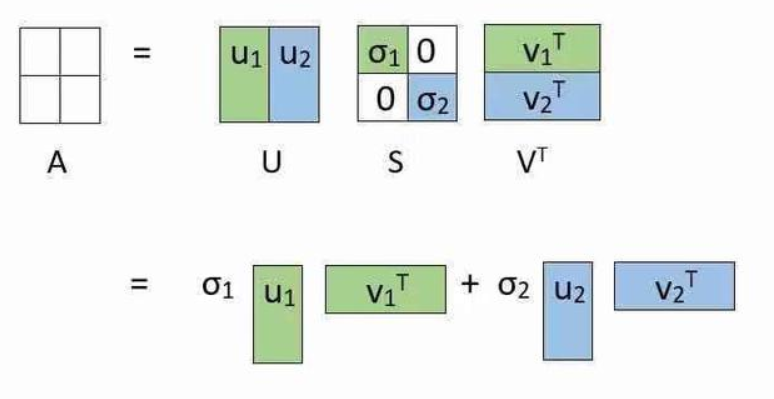

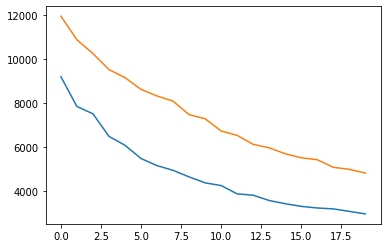

In [11]:
# check eigenvalues S1,S2
# since the first eigenvalue is too large..., we plot from the 4th 
plt.plot(S1[30:50]);
plt.plot(S2[30:50]);

In [15]:
aa = np.array([[1,2,3],
               [2,3,6]])

bb = np.array([[1,2],
               [3,5],
               [2,3]])
aa@ bb

array([[13, 21],
       [23, 37]])

In [16]:
np.matmul(aa,bb)

array([[13, 21],
       [23, 37]])

In [14]:
# GLRAM: MPCA的演算法之一
count = 3; # num of iterations
for i in range(count):
    # update A
    Bn = np.expand_dims(B,0) # --> [1,p2,q2]
    Bn = np.tile(Bn,[n,1,1]); # --> [n,p2,q2]
    XB = np.matmul(X,Bn); # --> [n,p1,q2]  # np.matmul(X,Bn) = X@Bn
    XB2 = unfold(XB,0); # --> [p1,n*q2]
    U1,S1,V1 = np.linalg.svd(XB2 @ XB2.T)
    A = U1[:,0:q1];
    
    # update B
    ATn = np.expand_dims(A.T,0) # --> [1,q1,p1]
    ATn = np.tile(ATn,[n,1,1]); # --> [n,q1,p1]
    AX = np.matmul(ATn,X); # --> [n,q1,p2]
    AX1 = unfold(AX,1); # --> [p2,n*q1]
    U2,S2,V2 = np.linalg.svd(AX1 @ AX1.T)
    B = U2[:,0:q2];
    
    # compute reconstruction error
    AATn = np.expand_dims(A @ A.T,0);
    AATn = np.tile(AATn,[n,1,1]);
    BBTn = np.expand_dims(B @ B.T,0);
    BBTn = np.tile(BBTn,[n,1,1]);
    X_ = AATn @ X @ BBTn;
    error = np.sum(np.sum(np.square(X-X_),axis=1),axis=1);
    print(np.mean(error));

473.88266
473.88272
473.88272


In [ ]:
# 對訓練資料和測試資料做降維
An = np.expand_dims(A, 0); # --> [1,p1,q1]
An = np.tile(An, [n,1,1]); # --> [n,p1,q1]
AnT = np.transpose(An, (0,2,1)); # --> [n,q1,p1]
Bn = np.expand_dims(B,0); # --> [1,p1,q1]
Bn = np.tile(Bn, [n,1,1]); # --> [n,p1,q1]
Xlow = AnT @ X @ Bn; # --> [n,q1,q2]
# 
Am = np.expand_dims(A, 0); # --> [1,p1,q1]
Am = np.tile(Am, [m,1,1]); # --> [n,p1,q1]
AmT = np.transpose(Am, (0,2,1)); # --> [n,q1,p1]
Bm = np.expand_dims(B,0); # --> [1,p1,q1]
Bm = np.tile(Bm, [m,1,1]); # --> [n,p1,q1]
Xtest_low = AmT @ Xtest @ Bm; # --> [n,q1,q2]
#
print('size of Xlow and Xtest_low:');
print(Xlow.shape);
print(Xtest_low.shape);

In [ ]:
# 基底畫圖
fig = plt.figure(figsize=(20,20))
for i in range(3):
    for j in range(3):
        ai = A[:,i:(i+1)];
        bj = B[:,j:(j+1)];
        basis_image = ai @ bj.T;
        ax = fig.add_subplot(5,5,i*5+j+1)
        ax.set_title("a{0} b{1}^T".format(i+1,j+1))
        img = ax.imshow(basis_image, cmap='gray', interpolation='nearest', origin='upper')
        cbar = fig.colorbar(img, ax=ax, aspect=50, pad=0.08, shrink=0.5, orientation='horizontal')

In [ ]:
# reconstruction畫圖
fig = plt.figure(figsize=(150,150))
num=4;
for i in range(num):
    ax = fig.add_subplot(num,2,2*i+1)
    ax.set_title("original {0}".format(i+1));
    img = ax.imshow(X[i], cmap='gray', interpolation='nearest', origin='upper')
    cbar = fig.colorbar(img, ax=ax, aspect=50, pad=0.08, shrink=0.25, orientation='horizontal')

    bx = fig.add_subplot(num,2,2*i+2)
    bx.set_title("reconstruction {0}".format(i+1));
    img = bx.imshow(X[i], cmap='gray', interpolation='nearest', origin='upper')
    cbar = fig.colorbar(img, ax=bx, aspect=50, pad=0.08, shrink=0.25, orientation='horizontal')

In [ ]:
# 對testing data 做reconstruction的動作
AATm = np.expand_dims(A @ A.T, 0);
BBTm = np.expand_dims(B @ B.T, 0);
AATm = np.tile(AATm,[m,1,1]);
BBTm = np.tile(BBTm,[m,1,1]);
Xtest_reconst = AATm @ Xtest @ BBTm;

In [ ]:
fig = plt.figure(figsize=(150,150))
num=4;
for i in range(num):
    ax = fig.add_subplot(num,2,2*i+1)
    ax.set_title("original {0}".format(i+1));
    img = ax.imshow(Xtest[i], cmap='gray', interpolation='nearest', origin='upper')
    cbar = fig.colorbar(img, ax=ax, aspect=50, pad=0.08, shrink=0.25, orientation='horizontal')

    bx = fig.add_subplot(num,2,2*i+2)
    bx.set_title("reconstruction {0}".format(i+1));
    img = bx.imshow(Xtest_reconst[i], cmap='gray', interpolation='nearest', origin='upper')
    cbar = fig.colorbar(img, ax=bx, aspect=50, pad=0.08, shrink=0.25, orientation='horizontal')

In [ ]:
######################## SVM分類器 ###########################

In [ ]:
# 將資料向量化
Xlow_vec = np.reshape(Xlow, [n,q1*q2], order='F');
Xtest_low_vec = np.reshape(Xtest_low, [m, q1*q2], order='F');

In [ ]:
# 訓練SVM 1
mysvm = svm.SVC(kernel='linear', C=1);  
mysvm.fit(Xlow_vec, Y);
Ytest_predict = mysvm.predict(Xtest_low_vec); # 預測
svm_accuracy = np.sum(Ytest == Ytest_predict) / m;
print(svm_accuracy);

mysvm2 = svm.SVC(kernel='rbf', C=1); # gamma = default for 'rbf'
mysvm2.fit(Xlow_vec, Y);
Ytest_predict = mysvm2.predict(Xtest_low_vec); # 預測
svm_accuracy = np.sum(Ytest == Ytest_predict) / m;
print(svm_accuracy);

In [ ]:
### Logistic regression

In [ ]:
# logistic via NN
model = tf.keras.Sequential()
model.add(tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones'));
model.add(tf.keras.layers.Dense(1, activation='sigmoid', input_shape=(q1*q2,)))
model.compile(loss='binary_crossentropy',optimizer='RMSprop',metrics=['accuracy'])
history = model.fit(Xlow_vec, Y, batch_size=100, epochs=100, verbose=1, validation_data=(Xtest_low_vec, Ytest))

In [ ]:
model.summary()

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')